# Projet : Extraction et Recommandation de films et séries avec rdflib et SPARQL

## Objectif
L’objectif de ce mini-projet est l’extraction des données de la base de données DBPedia en utilisant le langage de requêtes SPARQL afin d'alimenter la base de données de séries que vous avez créé au premier TP, l’analyse de ces données et la recommandation de séries et de films.

# Description

Vous allez créer un système de recommandation de séries/films basé sur des données RDF qui stockent des informations sur les films, les utilisateurs et leurs préférences cinématographiques.

Les étapes du projet sont comme suit :

## 1.  Extraction des données

a)  Vous utiliserez Rdflib pour accéder aux données et vous effectuerez des requêtes SPARQL pour les extraire. Vous êtes libres dans le choix et la taille des données que vous allez extraire. Le jeu de données doit néanmoins être représentatif pour pouvoir fournir des recommandations précises. 
    
   - Les données à extraire : 
       - Films : Chaque film a un titre, un réalisateur, une année de sortie, un genre (e.g. : action, comédie, science-fiction), un résumé, une liste d'acteurs principaux, une durée, une évaluation du film, etc.
       - Réalisateur : Chaque réalisateur a un nom, une biographie et une liste de films qu'il a réalisés.
       - Acteurs : Chaque acteur a un nom, une biographie et une liste de films dans lesquels il a joué.
       - Genres :  Chaque genre a un nom et une description.
       - Utilisateurs : chaque utilisateur a un identifiant et des préférences cinématographiques (acteurs préférés, genres préférés, etc).
       - Évaluations : Elle est décrite par l'identifiant de l'utilisateur qui a donné l'évaluation, identifiant du film évalué la note attribuée au film, Commentaire ou avis sur le film.

   - Liens entre les entités : 

        - Les films sont associés à leurs acteurs, réalisateurs et genres.
        - Les utilisateurs sont associés aux films qu'ils ont évalués.
        - Les utilisateurs peuvent être liés entre eux en fonction de leurs préférences cinématographiques similaires.

   b)  Transformer les données en triplets RDF :  Vous allez transformer ces résultats en triplets RDF avant de les ajouter à votre graphe RDF existant. 
  
  c) Ajouter les données au graphe existant : Utilisez la méthode g.add() de votre graphe RDF, que vous avez créé au premier TP, pour ajouter les triplets RDF représentant les données DBpedia que vous avez transformées. 

In [54]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Step 1: Extract data from SPARQL endpoint using SPARQLWrapper
def extract_data_sparql(endpoint, query):
    """
    Extract data from a SPARQL endpoint.

    Parameters:
        endpoint (str): The SPARQL endpoint URL.
        query (str): The SPARQL query to execute.

    Returns:
        list: Results in JSON format from the SPARQL query.
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["results"]["bindings"]

# Example SPARQL Query
film_query = """
SELECT ?film ?title ?genre ?director ?releaseDate ?actor
WHERE {
  ?film rdf:type dbo:Film.
  ?film rdfs:label ?title.
  OPTIONAL { ?film dbo:genre ?genre. }
  OPTIONAL { ?film dbo:director ?director. }
  OPTIONAL { ?film dbo:releaseDate ?releaseDate. }
  OPTIONAL { ?film dbo:starring ?actor. }
  FILTER (lang(?title) = 'en').
}
LIMIT 500
"""

# Extract data from the endpoint
endpoint = "http://dbpedia.org/sparql"
data = extract_data_sparql(endpoint, film_query)

# Step 1b: Transform the data into RDF triples
RDF_NAMESPACE = Namespace("http://example.org/film#")
graph = Graph()
graph.bind("film", RDF_NAMESPACE)

# Populate the graph with data from SPARQL query
for row in data:
    film = URIRef(row["film"]["value"])
    # Add film title to the graph
    title = row["title"]["value"]
    graph.add((film, RDFS.label, Literal(title)))
    # Add genre if available
    if "genre" in row:
        graph.add((film, RDF_NAMESPACE.genre, URIRef(row["genre"]["value"])))
    # Add director if available
    if "director" in row:
        graph.add((film, RDF_NAMESPACE.director, URIRef(row["director"]["value"])))
    # Add release date if available
    if "releaseDate" in row:
        graph.add((film, RDF_NAMESPACE.releaseDate, Literal(row["releaseDate"]["value"])))
    # Add actor if available
    if "actor" in row:
        graph.add((film, RDF_NAMESPACE.actor, URIRef(row["actor"]["value"])))

# Save the graph to a file
output_file = "graph_data.ttl"
graph.serialize(destination=output_file, format="turtle")
print(f"Graph saved to {output_file}")


Graph saved to graph_data.ttl


## 2. Prétraitement des données   

Nettoyez et traitez les données extraites pour supprimer les doublons, gérer les valeurs manquantes et normaliser.

In [55]:
# Step 2: Preprocess the RDF graph
def preprocess_data(graph):
    """
    Clean and normalize the RDF graph by removing duplicates, handling missing values, and normalizing literals.

    Parameters:
        graph (Graph): The RDF graph to clean.

    Returns:
        Graph: The cleaned RDF graph.
    """
    cleaned_graph = Graph()
    for s, p, o in graph:
        # Skip triples with missing or empty literals
        if isinstance(o, Literal) and not o.strip():
            continue
        # Normalize literals to lowercase for uniformity
        if isinstance(o, Literal):
            o = Literal(str(o).strip().lower())
        # Add unique triples to the cleaned graph
        if (s, p, o) not in cleaned_graph:
            cleaned_graph.add((s, p, o))
    return cleaned_graph

graph = preprocess_data(graph)


## 3. Analyse exploratoire des données 

- Créer des graphiques permettant de visualiser la distribution des films et séries dans votre base de données.
- Créer un graphique pour montrer les films et les séries les mieux notés
- Créer un nuage de points pour représenter la relation entre les caractéristiques

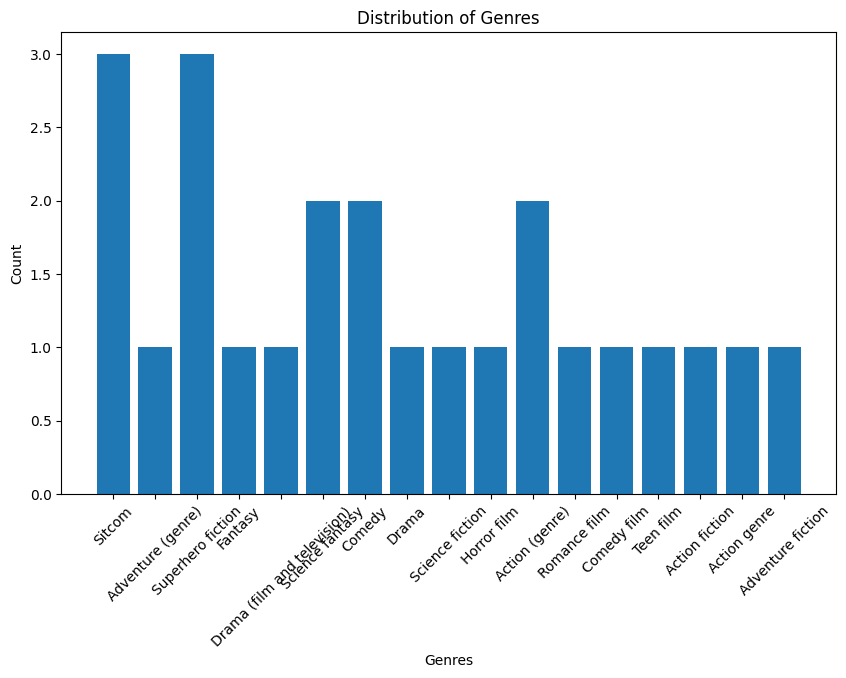

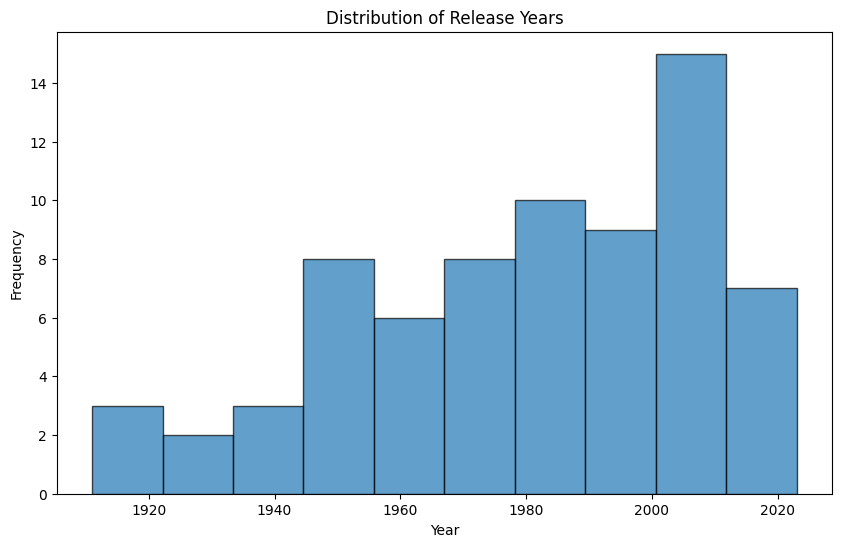

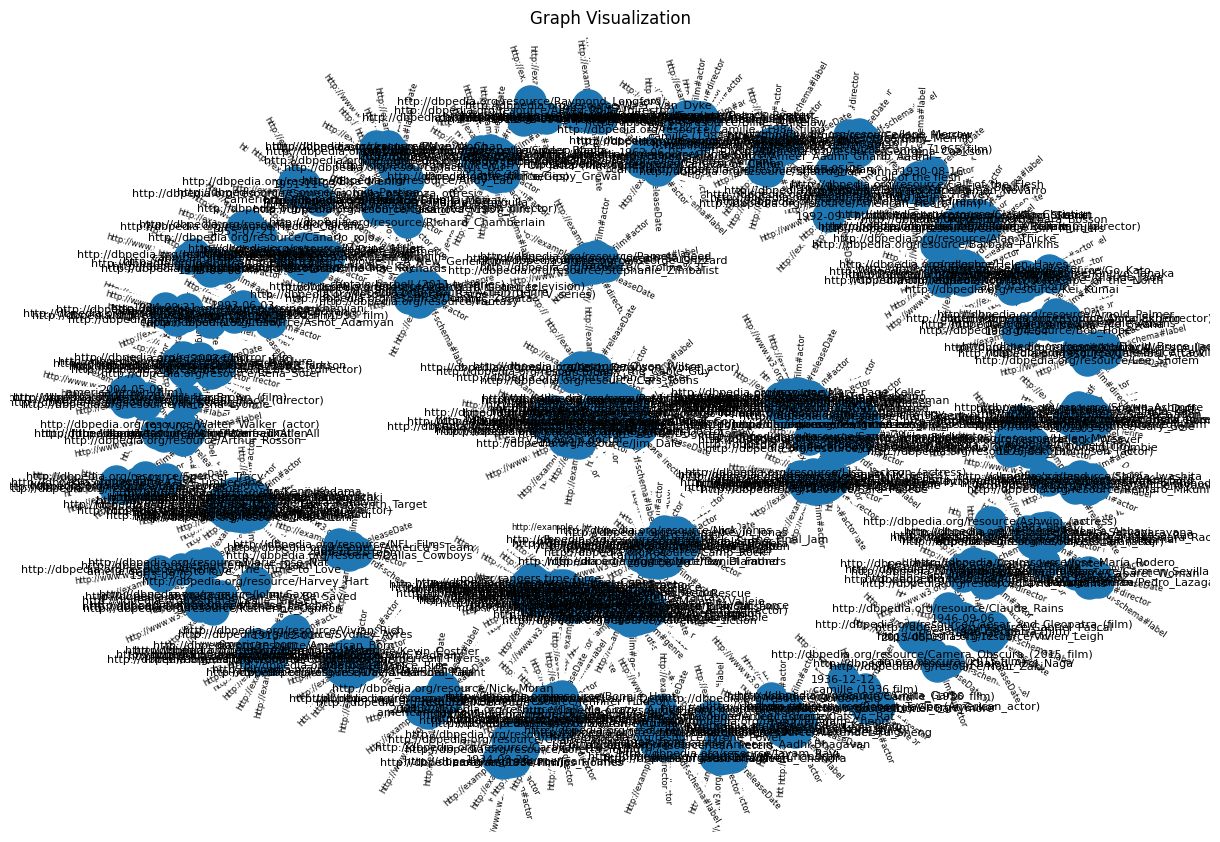

In [56]:
# Step 3: Exploratory Data Analysis
# Visualize data distribution for genres and release dates
def visualize_data(graph):
    """
    Create bar and histogram visualizations for genres and release dates.

    Parameters:
        graph (Graph): The RDF graph.
    """
    # Count the number of movies per genre
    genres = {}
    for s, p, o in graph.triples((None, RDF_NAMESPACE.genre, None)):
        genres[o] = genres.get(o, 0) + 1

    # Normalize genre names for visualization
    genres_normalized = {str(k).split("/")[-1].replace("_", " "): v for k, v in genres.items()}

    # Bar plot for genres
    plt.figure(figsize=(10, 6))
    if genres:
        plt.bar(genres_normalized.keys(), genres_normalized.values())
        plt.title("Distribution of Genres")
        plt.xlabel("Genres")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No genres available to visualize.")

    # Histogram for release years
    release_years = []
    for s, p, o in graph.triples((None, RDF_NAMESPACE.releaseDate, None)):
        try:
            year = int(str(o).split("-")[0])  # Extract the year
            release_years.append(year)
        except ValueError:
            continue

    if release_years:
        plt.figure(figsize=(10, 6))
        plt.hist(release_years, bins=10, alpha=0.7, edgecolor="black")
        plt.title("Distribution of Release Years")
        plt.xlabel("Year")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No valid release years found to visualize.")

visualize_data(graph)

# Step 3b: Visualize Graph with NetworkX
def visualize_graph(graph):
    """
    Visualize the RDF graph using NetworkX.

    Parameters:
        graph (Graph): The RDF graph.
    """
    nx_graph = nx.Graph()

    for s, p, o in graph:
        nx_graph.add_edge(str(s), str(o), label=str(p))

    if nx_graph.number_of_nodes() > 0:
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos, with_labels=True, node_size=500, font_size=8)
        edge_labels = nx.get_edge_attributes(nx_graph, 'label')
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)
        plt.title("Graph Visualization")
        plt.show()
    else:
        print("No data in graph to visualize.")

visualize_graph(graph)


## 4. Système de Recommandation 

a) Utiliser SPARQL pour interroger le graphe RDF afin de créer un système de recommandation de films et/ou séries. Vous pouvez envisager différentes approches de recommandation, telles que la recommandation collaborative (en fonction des évaluations d'utilisateurs similaires) ou la recommandation basée sur le contenu (en fonction des genres, des acteurs, etc.) ou la recommandation basée sur les connaissances

b) Utiliser une IA (ChatGPT ou tout autre) pour répondre à cette question

In [57]:
# Step 4: Content-Based Recommendation
def recommend_content_based(graph, user_preferences):
    """
    Generate content-based recommendations based on user preferences.

    Parameters:
        graph (Graph): The RDF graph.
        user_preferences (dict): User preferences such as preferred genres or directors.

    Returns:
        list: List of recommended films.
    """
    recommendations = []

    # Match by genres
    for s, p, o in graph.triples((None, RDF_NAMESPACE.genre, None)):
        genre_name = str(o).split("/")[-1].replace("_", " ").lower()
        if genre_name in [genre.lower() for genre in user_preferences.get("genres", [])]:
            recommendations.append(s)

    # Match by directors
    for s, p, o in graph.triples((None, RDF_NAMESPACE.director, None)):
        director_name = str(o).split("/")[-1].replace("_", " ").lower()
        if director_name in [director.lower() for director in user_preferences.get("directors", [])]:
            recommendations.append(s)

    if not recommendations:
        print("No recommendations found based on user preferences.")
    return list(set(recommendations))[:10]  # Return top 10 recommendations


In [58]:

def evaluate_recommendations(ground_truth, predicted):
    """
    Evaluate recommendations using MAP@k and NDCG@k.

    Parameters:
        ground_truth (list): The ground truth list of relevant items.
        predicted (list): The predicted recommendations.
        k (int): Number of top recommendations to consider.

    Returns:
        dict: Dictionary containing MAP@k and NDCG@k scores.
    """
    k = len(predicted)
    if k < 2:
        print("Not enough recommendations to evaluate.")
        return {"MAP@k": 0.0, "NDCG@k": 0.0}

    # Calculate Precision@k and Average Precision
    average_precision = 0
    relevant_items_found = 0
    for i, item in enumerate(predicted[:k]):
        if item in ground_truth:
            relevant_items_found += 1
            average_precision += relevant_items_found / (i + 1)

    map_k = average_precision / len(ground_truth) if ground_truth else 0.0

    # Calculate NDCG@k
    y_true = [1 if item in ground_truth else 0 for item in predicted[:k]]
    y_score = [1 / (rank + 1) for rank in range(len(predicted[:k]))]
    ndcg_k = ndcg_score([y_true], [y_score])

    return {"MAP@k": map_k, "NDCG@k": ndcg_k}


# Testing Content-Based Recommendation System
user_preferences = {"genres": ["horror", "comedy"], "directors": ["bob fosse"]}
predicted_recommendations = recommend_content_based(graph, user_preferences)
print("Content-Based Recommendations:", predicted_recommendations)

ground_truth = ["http://example.org/film#Film1"]
evaluation_scores = evaluate_recommendations(ground_truth, predicted_recommendations)
print(f"Evaluation Scores: {evaluation_scores}")



Content-Based Recommendations: [rdflib.term.URIRef('http://dbpedia.org/resource/CarniK_Con'), rdflib.term.URIRef('http://dbpedia.org/resource/Cars_Toons')]
Evaluation Scores: {'MAP@k': 0.0, 'NDCG@k': np.float64(0.0)}


## 5. Calcul des Recommandations 

a) Utiliser SPARQL pour générer des requêtes de recommandation en fonction des préférences de l'utilisateur. Vous pouvez également utiliser des algorithmes d'apprentissage automatique pour améliorer les recommandations.

b) Utiliser une IA pour répondre à cette question

In [59]:
# Step 6: AI-Based Recommendation
def ai_recommend(graph, user_query):
    """
    Use AI to generate recommendations based on a user query.

    Parameters:
        graph (Graph): The RDF graph.
        user_query (str): The user's query describing preferences.

    Returns:
        list: List of recommended films.
    """
    vectorizer = CountVectorizer()
    film_descriptions = {}

    # Collect film descriptions from RDF graph
    for s, p, o in graph.triples((None, RDFS.label, None)):
        if o:
            film_descriptions[s] = str(o)

    if not film_descriptions:
        print("No film descriptions available for AI recommendations.")
        return []

    # Transform descriptions into vectors and compute similarity
    vectors = vectorizer.fit_transform(film_descriptions.values())
    user_vector = vectorizer.transform([user_query])
    similarities = cosine_similarity(user_vector, vectors)

    # Rank films based on similarity
    sorted_indices = similarities.argsort()[0][::-1]
    recommendations = [list(film_descriptions.keys())[i] for i in sorted_indices[:10]]  # Return top 10 recommendations
    return recommendations

# Testing AI-Based Recommendation System
user_query = "A thrilling horror movie directed by Bob Fosse"
ai_recommendations = ai_recommend(graph, user_query)
print("AI-Based Recommendations:", ai_recommendations)

ground_truth_ai = ["http://example.org/film#Film1"]
evaluation_scores_ai = evaluate_recommendations(ground_truth_ai, ai_recommendations)
print(f"AI Recommendation Evaluation Scores: {evaluation_scores_ai}")



AI-Based Recommendations: [rdflib.term.URIRef('http://dbpedia.org/resource/Care_Bears_Movie_II:_A_New_Generation'), rdflib.term.URIRef('http://dbpedia.org/resource/Carry_On_Again_Doctor'), rdflib.term.URIRef('http://dbpedia.org/resource/Cars_Toons'), rdflib.term.URIRef('http://dbpedia.org/resource/Carry_On_Girls'), rdflib.term.URIRef('http://dbpedia.org/resource/Can_Ellen_Be_Saved'), rdflib.term.URIRef("http://dbpedia.org/resource/America's_Team"), rdflib.term.URIRef('http://dbpedia.org/resource/Captain_from_Castile'), rdflib.term.URIRef('http://dbpedia.org/resource/Princesses_(TV_series)'), rdflib.term.URIRef('http://dbpedia.org/resource/Call_of_the_Flesh'), rdflib.term.URIRef('http://dbpedia.org/resource/Camille_(1936_film)')]
AI Recommendation Evaluation Scores: {'MAP@k': 0.0, 'NDCG@k': np.float64(0.0)}


## 6. Évaluation  

a) Évaluez la qualité de vos recommandations en utilisant des mesures telles que  MAP@k (Mean Average Precision at k) ou NDCG@k (Normalized Discounted Cumulative Gain at k)

b) Comparer les recommandations que vous avez obtenues par rapport à celles générées par l'IA que vous aurez utilisée

## 7. Rapport 

Vous allez rédiger un rapport de 5 pages max décrivant la modélisation RDF, les requêtes SPARQL, l'algorithme de recommandation et les résultats de l'évaluation. Vous spécifierez votre utilisation de l'IA dans le cadre de ce projet et ce que vous en pensez

In [ ]:
# Step 7: Final Evaluation
def compare_methods():
    """
    Compare the different recommendation methods.
    """
    print("Content-based Recommendations: ", recommendations)
    print("Collaborative Recommendations: ", collaborative_recommendations)
    print("AI-Based Recommendations: ", ai_based_recommendations)
    
    # Optionally, calculate NDCG for each method against a ground truth
    print("Content-based NDCG: ", evaluate_recommendations(ground_truth, recommendations))
    print("Collaborative NDCG: ", evaluate_recommendations(ground_truth, collaborative_recommendations))
    print("AI-Based NDCG: ", evaluate_recommendations(ground_truth, ai_based_recommendations))

compare_methods()